In [135]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
colors = ['#435E72']

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
imdb = pd.read_csv("movies_dataset.csv", encoding='latin-1')
imdb.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [6]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [8]:
imdb.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [10]:
nulls = imdb[imdb.iloc[:, 1:9].isna().all(axis=1)]
nulls.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1836,Bang Bang Reloaded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,Battle of bittora,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2653,Campus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3403,Dancing Dad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3807,Dial 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
for col in imdb.select_dtypes(include = "object"):
    print(f"Name of Column: {col}")
    print(imdb[col].unique())
    print('\n', '-'*60, '\n')

Name of Column: Name
[' ' '#Gadhvi (He thought he was Gandhi)' '#Homecoming' ... 'Zulmi Raj'
 'Zulmi Shikari' 'Zulm-O-Sitam']

 ------------------------------------------------------------ 

Name of Column: Year
[nan '(2019)' '(2021)' '(2010)' '(1997)' '(2005)' '(2008)' '(2012)'
 '(2014)' '(2004)' '(2016)' '(1991)' '(1990)' '(2018)' '(1987)' '(1948)'
 '(1958)' '(2017)' '(2020)' '(2009)' '(2002)' '(1993)' '(1946)' '(1994)'
 '(2007)' '(2013)' '(2003)' '(1998)' '(1979)' '(1951)' '(1956)' '(1974)'
 '(2015)' '(2006)' '(1981)' '(1985)' '(2011)' '(2001)' '(1967)' '(1988)'
 '(1995)' '(1959)' '(1996)' '(1970)' '(1976)' '(2000)' '(1999)' '(1973)'
 '(1968)' '(1943)' '(1953)' '(1986)' '(1983)' '(1989)' '(1982)' '(1977)'
 '(1957)' '(1950)' '(1992)' '(1969)' '(1975)' '(1947)' '(1972)' '(1971)'
 '(1935)' '(1978)' '(1960)' '(1944)' '(1963)' '(1940)' '(1984)' '(1934)'
 '(1955)' '(1936)' '(1980)' '(1966)' '(1949)' '(1962)' '(1964)' '(1952)'
 '(1933)' '(1942)' '(1939)' '(1954)' '(1945)' '(1961)' '(1965)'

In [14]:
imdb.dropna(subset=['Name', 'Year', 'Duration', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], inplace=True)

In [16]:
imdb['Name'] = imdb['Name'].str.extract('([A-Za-z\s\'\-]+)')

In [18]:
imdb['Year'] = imdb['Year'].str.replace(r'[()]', '', regex=True).astype(int)


In [20]:
imdb['Duration'] = pd.to_numeric(imdb['Duration'].str.replace(r' min', '', regex=True), errors='coerce')

In [22]:
imdb['Genre'] = imdb['Genre'].str.split(', ')
imdb = imdb.explode('Genre')
imdb['Genre'].fillna(imdb['Genre'].mode()[0], inplace=True)

In [24]:
imdb['Votes'] = pd.to_numeric(imdb['Votes'].str.replace(',', ''), errors='coerce')

In [26]:
duplicate = imdb.groupby(['Name', 'Year']).filter(lambda x: len(x) > 1)
duplicate.head(5)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
3,Yaaram,2019,110,Comedy,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
3,Yaaram,2019,110,Romance,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,Aur Pyaar Ho Gaya,1997,147,Comedy,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
5,Aur Pyaar Ho Gaya,1997,147,Drama,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
5,Aur Pyaar Ho Gaya,1997,147,Musical,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [28]:
imdb = imdb.drop_duplicates(subset=['Name'], keep=False)

In [30]:
imdb.describe()

,Year,Duration,Rating,Votes
count,1528.000000,1528.000000,1528.000000,1528.000000
mean,1997.972513,123.823953,5.976243,552.479712
std,21.181921,25.108144,1.412547,4311.631841
min,1931.000000,45.000000,1.600000,5.000000
25%,1985.000000,107.000000,5.100000,14.000000
50%,2004.000000,126.000000,6.100000,34.000000
75%,2016.000000,140.000000,7.000000,127.250000
max,2021.000000,300.000000,9.400000,101014.000000


In [32]:
imdb.describe(include = 'O')

,Name,Genre,Director,Actor 1,Actor 2,Actor 3
count,1528,1528,1528,1528,1528,1528
unique,1528,20,1114,1010,1131,1154
top,Gadhvi,Drama,Kanti Shah,Mithun Chakraborty,Mithun Chakraborty,Pran
freq,1,789,13,22,12,16


In [36]:
max_votes_row = imdb[imdb['Votes'] == imdb['Votes'].max()]
movie_highest_votes = max_votes_row['Name'].values[0]

In [40]:
votes_highest_votes = max_votes_row['Votes'].values[0]

In [42]:
print("Movie with the highest votes:", movie_highest_votes)
print("Number of votes for the movie with the highest votes:", votes_highest_votes)
print('\n', '='*100, '\n')

Movie with the highest votes: My Name Is Khan
Number of votes for the movie with the highest votes: 101014




In [44]:
min_votes_row = imdb[imdb['Votes'] == imdb['Votes'].min()]

movie_lowest_votes = min_votes_row['Name'].values[0]

votes_lowest_votes = min_votes_row['Votes'].values[0]

In [46]:
print("Movie with the highest votes:", movie_lowest_votes)
print("Number of votes for the movie with the highest votes:", votes_lowest_votes)


Movie with the highest votes: Anmol Sitaare
Number of votes for the movie with the highest votes: 5


In [48]:
max_rating_row = imdb[imdb['Rating'] == imdb['Rating'].max()]
movie_highest_rating = max_rating_row['Name'].values[0]
votes_highest_rating = max_rating_row['Votes'].values[0]

In [50]:
print("Movie with the highest rating:", movie_highest_rating)
print("Number of votes for the movie with the highest rating:", votes_highest_rating)
print('\n', '='*100, '\n')


Movie with the highest rating: June
Number of votes for the movie with the highest rating: 18




In [54]:
min_rating_row = imdb[imdb['Rating'] == imdb['Rating'].min()]
movie_lowest_rating = min_rating_row['Name'].values[0]
votes_lowest_rating = min_rating_row['Votes'].values[0]

print("Movie with the Lowest rating:", movie_lowest_rating)
print("Number of votes for the movie with the Lowest rating:", votes_lowest_rating)

Movie with the Lowest rating: Mumbai Can Dance Saalaa
Number of votes for the movie with the Lowest rating: 43


In [60]:
director_counts = imdb['Director'].value_counts()
director_counts

Director
Kanti Shah                    13
Shyam Benegal                 12
Shantaram Rajaram Vankudre    11
Kalpataru                      8
Shakti Samanta                 8
                              ..
Salar Shaikh                   1
Anand Patwardhan               1
Dayanand                       1
V.G. Samant                    1
Mozez Singh                    1
Name: count, Length: 1114, dtype: int64

In [66]:
most_prolific_director = director_counts.idxmax()
print(most_prolific_director)
num_movies_directed = director_counts.max()
num_movies_directed

Kanti Shah


13

In [68]:
least_prolific_director = director_counts.idxmin()
print(least_prolific_director)
num_movies_directed = director_counts.min()
num_movies_directed

Sikandar Khanna


1

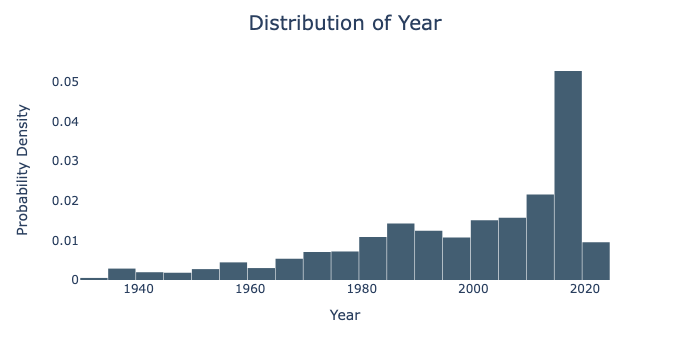

In [96]:
fig_year = px.histogram(imdb, x = 'Year', histnorm='probability density', nbins = 30, color_discrete_sequence = colors)
fig_year.update_traces(selector=dict(type='histogram'))
fig_year.update_layout(title='Distribution of Year', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Year', yaxis_title='Probability Density', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), bargap=0.02, plot_bgcolor = 'white')
fig_year.show()

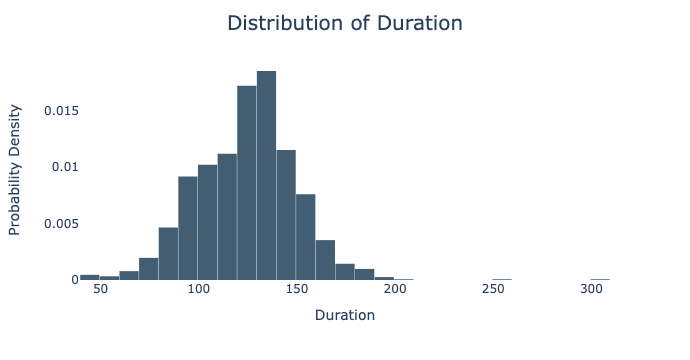

In [98]:
fig_duration = px.histogram(imdb, x = 'Duration', histnorm='probability density', nbins = 40, color_discrete_sequence = colors)
fig_duration.update_traces(selector=dict(type='histogram'))
fig_duration.update_layout(title='Distribution of Duration', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Duration', yaxis_title='Probability Density', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), bargap=0.02, plot_bgcolor = 'white')
fig_duration.show()

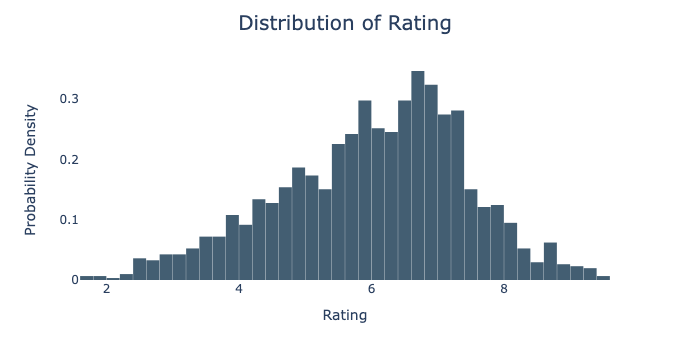

In [100]:
fig_rating = px.histogram(imdb, x = 'Rating', histnorm='probability density', nbins = 40, color_discrete_sequence = colors)
fig_rating.update_traces(selector=dict(type='histogram'))
fig_rating.update_layout(title='Distribution of Rating', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Rating', yaxis_title='Probability Density', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), bargap=0.02, plot_bgcolor = 'white')
fig_rating.show()

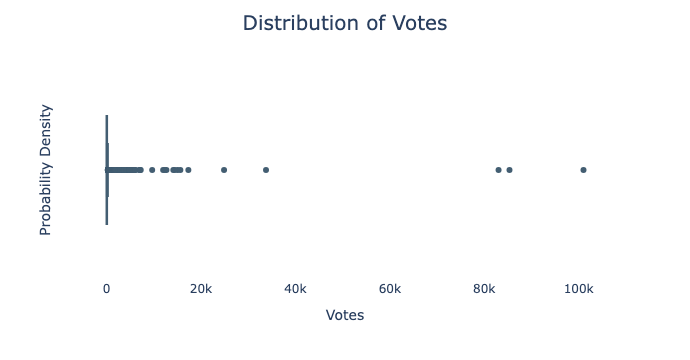

In [102]:
fig_votes = px.box(imdb, x = 'Votes', color_discrete_sequence = colors)
fig_votes.update_layout(title='Distribution of Votes', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Votes', yaxis_title='Probability Density', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), plot_bgcolor = 'white')
fig_votes.show()

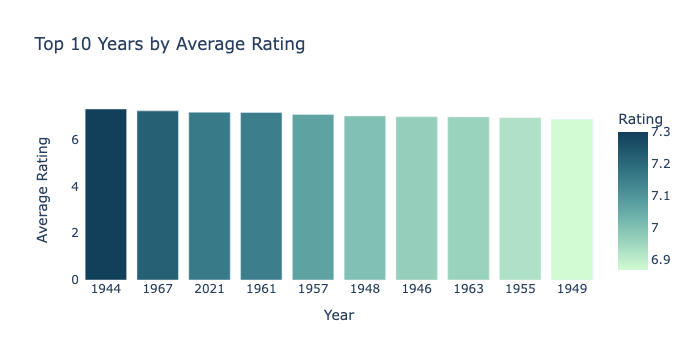

In [104]:
year_avg_rating = imdb.groupby('Year')['Rating'].mean().reset_index()

top_5_years = year_avg_rating.nlargest(10, 'Rating')
fig = px.bar(top_5_years, x='Year', y='Rating', title='Top 10 Years by Average Rating', color = "Rating", color_continuous_scale = "darkmint")
fig.update_xaxes(type='category')  
fig.update_layout(xaxis_title='Year', yaxis_title='Average Rating', plot_bgcolor = 'white')
fig.show()

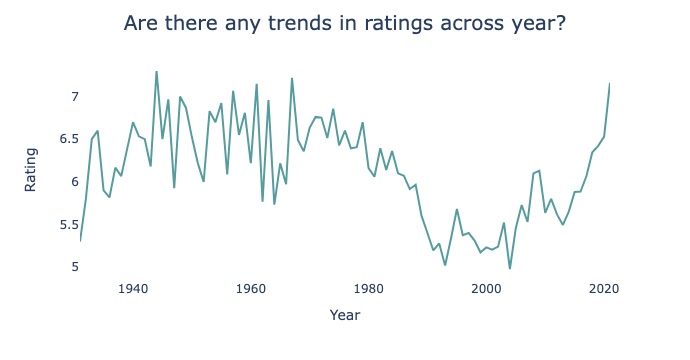

In [112]:

average_rating_by_year = imdb.groupby('Year')['Rating'].mean().reset_index()


fig = px.line(average_rating_by_year, x='Year', y='Rating', color_discrete_sequence=['#559C9E'])
fig.update_layout(title='Are there any trends in ratings across year?', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Year', yaxis_title='Rating', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), plot_bgcolor = 'white')
fig.show()

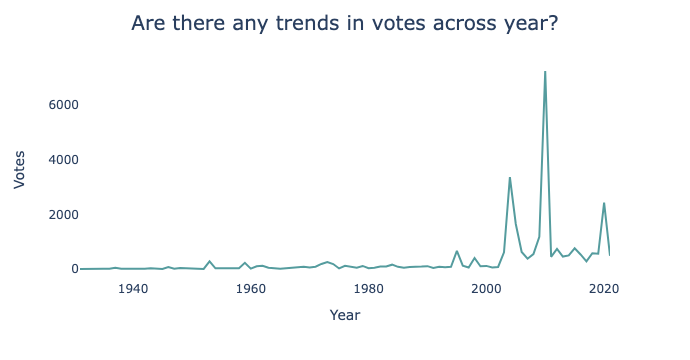

In [116]:

average_rating_by_year = imdb.groupby('Year')['Votes'].mean().reset_index()


fig = px.line(average_rating_by_year, x='Year', y='Votes', color_discrete_sequence=['#559C9E'])
fig.update_layout(title='Are there any trends in votes across year?', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Year', yaxis_title='Votes', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), plot_bgcolor = 'white')
fig.show()


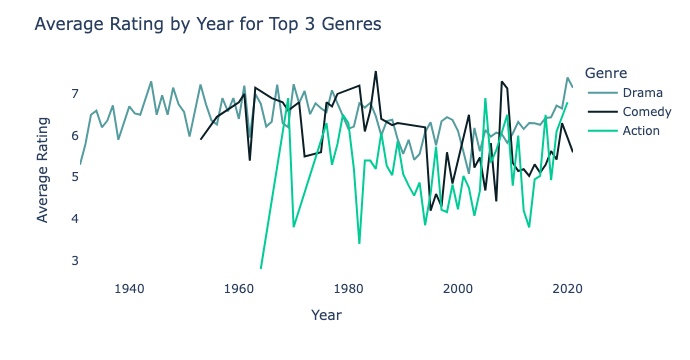

In [118]:

average_rating_by_year = imdb.groupby(['Year', 'Genre'])['Rating'].mean().reset_index()

top_3_genres = imdb['Genre'].value_counts().head(3).index

average_rating_by_year = average_rating_by_year[average_rating_by_year['Genre'].isin(top_3_genres)]

fig = px.line(average_rating_by_year, x='Year', y='Rating', color = "Genre", color_discrete_sequence=['#559C9E', '#0B1F26', '#00CC96'])

fig.update_layout(title='Average Rating by Year for Top 3 Genres', xaxis_title='Year', yaxis_title='Average Rating', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), plot_bgcolor='white')

fig.show()

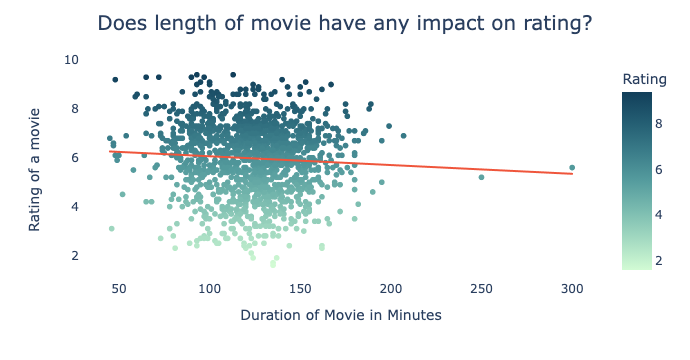

In [121]:
fig_dur_rat = px.scatter(imdb, x = 'Duration', y = 'Rating', trendline='ols', color = "Rating", color_continuous_scale = "darkmint")
fig_dur_rat.update_layout(title='Does length of movie have any impact on rating?', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Duration of Movie in Minutes', yaxis_title='Rating of a movie', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), plot_bgcolor = 'white')
fig_dur_rat.show()

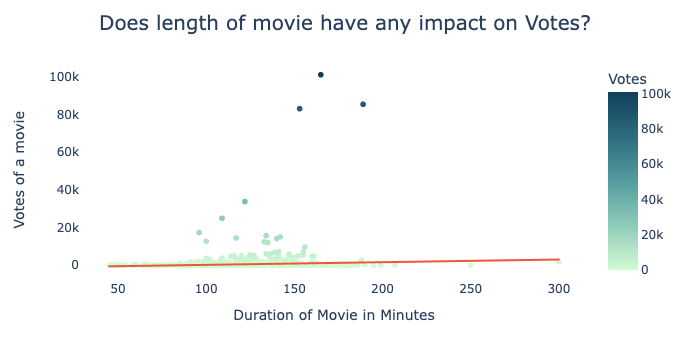

In [123]:
fig_dur_votes = px.scatter(imdb, x = 'Duration', y = 'Votes', trendline='ols', color = "Votes", color_continuous_scale = "darkmint")
fig_dur_votes.update_layout(title='Does length of movie have any impact on Votes?', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Duration of Movie in Minutes', yaxis_title='Votes of a movie', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), plot_bgcolor = 'white')
fig_dur_votes.show()

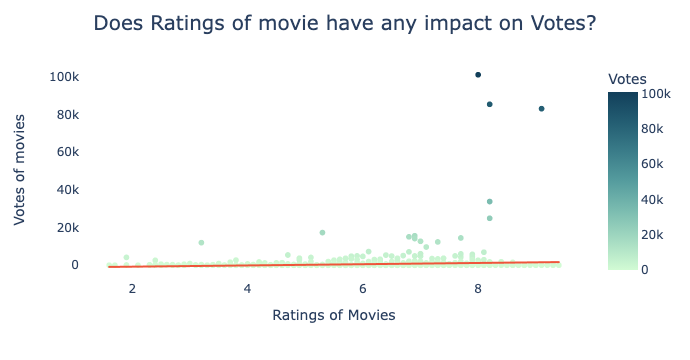

In [125]:
fig_rat_votes = px.scatter(imdb, x = 'Rating', y = 'Votes', trendline='ols', color = "Votes", color_continuous_scale = "darkmint")
fig_rat_votes.update_layout(title='Does Ratings of movie have any impact on Votes?', title_x=0.5, title_pad=dict(t=20), title_font=dict(size=20), xaxis_title='Ratings of Movies', yaxis_title='Votes of movies', xaxis=dict(showgrid=False), yaxis=dict(showgrid=False), plot_bgcolor = 'white')
fig_rat_votes.show()

In [127]:
imdb.drop('Name', axis = 1, inplace = True)

In [129]:

genre_mean_rating = imdb.groupby('Genre')['Rating'].transform('mean')
imdb['Genre_mean_rating'] = genre_mean_rating

director_mean_rating = imdb.groupby('Director')['Rating'].transform('mean')
imdb['Director_encoded'] = director_mean_rating

actor1_mean_rating = imdb.groupby('Actor 1')['Rating'].transform('mean')
imdb['Actor1_encoded'] = actor1_mean_rating

actor2_mean_rating = imdb.groupby('Actor 2')['Rating'].transform('mean')
imdb['Actor2_encoded'] = actor2_mean_rating

actor3_mean_rating = imdb.groupby('Actor 3')['Rating'].transform('mean')
imdb['Actor3_encoded'] = actor3_mean_rating

In [131]:
X = imdb[[ 'Year', 'Votes', 'Duration', 'Genre_mean_rating','Director_encoded','Actor1_encoded', 'Actor2_encoded', 'Actor3_encoded']]
y = imdb['Rating']

In [133]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [143]:

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)


rf = RandomForestRegressor()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)



In [145]:
print('The performance evaluation of Logistic Regression is below: ', '\n')
print('Mean squared error: ',mean_squared_error(y_test, lr_pred))
print('Mean absolute error: ',mean_absolute_error(y_test, lr_pred))
print('R2 score: ',r2_score(y_test, lr_pred))
print('\n', '='*100, '\n')

print('The performance evaluation of Random Forest Regressor is below: ', '\n')
print('Mean squared error: ',mean_squared_error(y_test, rf_pred))
print('Mean absolute error: ',mean_absolute_error(y_test, rf_pred))
print('R2 score: ',r2_score(y_test, rf_pred))

The performance evaluation of Logistic Regression is below:  

Mean squared error:  0.13007622782536266
Mean absolute error:  0.2507994097724829
R2 score:  0.935188545523222


The performance evaluation of Random Forest Regressor is below:  

Mean squared error:  0.11448097385620909
Mean absolute error:  0.19013071895424893
R2 score:  0.9429589975848592


In [147]:
X.head()

,Year,Votes,Duration,Genre_mean_rating,Director_encoded,Actor1_encoded,Actor2_encoded,Actor3_encoded
1,2019,8,109,6.420152,7.000,6.850000,7.000000,7.000
10,2004,17,96,6.420152,6.200,5.766667,5.100000,6.200
11,2016,59,120,4.698529,5.900,5.900000,5.900000,5.900
30,2005,1002,116,6.420152,6.525,6.900000,6.866667,5.700
32,1993,15,168,6.420152,5.400,5.600000,6.400000,5.825


In [149]:
y.head()

1     7.0
10    6.2
11    5.9
30    7.1
32    5.6
Name: Rating, dtype: float64

In [151]:
data = {'Year': [2016], 'Votes': [58], 'Duration': [121], 'Genre_mean_rating': [4.5], 'Director_encoded': [5.8], 'Actor1_encoded': [5.9], 'Actor2_encoded': [5.9], 'Actor3_encoded': [5.900]}
df = pd.DataFrame(data)

In [153]:
predicted_rating = rf.predict(df)

# Display the predicted rating
print("Predicted Rating:", predicted_rating[0])

Predicted Rating: 5.853999999999996
